# AI Sign Language Translator - Improved Training Pipeline

This notebook synchronizes with `src/scripts/train_improved.py` to provide a robust training environment with data augmentation, normalization, and advanced visualizations.

In [1]:
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Setup paths relative to notebook location
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))
sys.path.append(PROJECT_ROOT)

from src.utils.preprocessor import normalize_keypoints

print(f"Project Root: {PROJECT_ROOT}")

Project Root: c:\Users\Shubham\Documents\AI Sign Language Translator


## 1. Data Augmentation & Generator
Implemented noise, scaling, shifting, masking (hand loss simulation), aspect ratio, rotation, speed variation, and mirroring.

In [2]:
def resample_sequence(sequence, target_length=30):
    sequence = np.array(sequence)
    if len(sequence) == target_length:
        return sequence
    indices = np.linspace(0, len(sequence) - 1, target_length).astype(int)
    return sequence[indices]

def augment_landmarks(sequence, type='noise'):
    augmented = np.array(sequence, dtype=np.float32)
    
    if type == 'noise':
        # REAL-WORLD HARDENING: Increased noise to handle low-quality webcams
        noise = np.random.normal(0, 0.015, augmented.shape)
        augmented += noise
    
    elif type == 'scale':
        # Simulated Distance Variation (Scaling)
        scale = np.random.uniform(0.85, 1.15) 
        augmented *= scale
        
    elif type == 'shift':
        # Temporal Shift (Simulation of sign starting late or early)
        shift = np.random.randint(-4, 4)
        augmented = np.roll(augmented, shift, axis=0)
        
    elif type == 'mask':
        # Real-World Fix: Simulated Hand Tracking Loss (Masking)
        # Randomly zero out one hand in 20% of training samples
        if np.random.rand() > 0.8:
            choice = np.random.choice(['left', 'right'])
            if choice == 'left':
                augmented[:, 132:195] = 0 # LH Range
            else:
                augmented[:, 195:258] = 0 # RH Range
                
    elif type == 'aspect':
        # Simulated Body Shape Variation (Thinner/Wider people)
        # Scale X coordinates only
        ratio = np.random.uniform(0.9, 1.1)
        augmented[:, 0::3] *= ratio # Scale X columns
        
    elif type == 'rotate':
        # Simulated Camera Tilt / Posture
        angle = np.radians(np.random.uniform(-10, 10))
        c, s = np.cos(angle), np.sin(angle)
        # Rotate X,Y around center (assuming normalized approx 0,0)
        # Note: input is (30, 258). X at 0,3,6... Y at 1,4,7...
        x = augmented[:, 0::3]
        y = augmented[:, 1::3]
        new_x = x * c - y * s
        new_y = x * s + y * c
        augmented[:, 0::3] = new_x
        augmented[:, 1::3] = new_y
            
    elif type == 'speed':
        # Time Stretch (Simulation of fast/slow signing)
        speed_factor = np.random.uniform(0.7, 1.4)
        current_len = augmented.shape[0] # 30
        new_len = int(current_len * speed_factor)
        
        # Resample
        resampled = np.zeros((new_len, augmented.shape[1]))
        for i in range(augmented.shape[1]):
            resampled[:, i] = np.interp(
                np.linspace(0, current_len, new_len),
                np.arange(current_len),
                augmented[:, i]
            )
            
        # Fit back to 30 frames
        if new_len > 30:
            start = (new_len - 30) // 2
            augmented = resampled[start:start+30]
        else:
            augmented = np.zeros((30, augmented.shape[1]))
            start = (30 - new_len) // 2
            augmented[start:start+new_len] = resampled
            
    elif type == 'mirror':
        # Simulated Mirroring (Left-handed signing handling)
        # Flip X coordinates
        augmented[:, 0::3] *= -1

    return augmented

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=32, augment=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        
        if self.augment:
            aug_x = []
            for seq in batch_x:
                aug_type = random.choice(['original', 'noise', 'shift', 'speed', 'mask', 'aspect', 'rotate', 'mirror']) 
                if aug_type == 'original':
                    aug_x.append(seq)
                else:
                    aug_x.append(augment_landmarks(seq, type=aug_type))
            return np.array(aug_x), batch_y
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.augment:
            np.random.shuffle(self.indices)

## 2. Load and Preprocess Data

In [3]:
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')

if not os.path.exists(MODELS_DIR): os.makedirs(MODELS_DIR)

num_top_classes = 400 # Set high to include all available classes

all_actions = [folder for folder in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, folder))]
action_counts = {}

for action in all_actions:
    files = [f for f in os.listdir(os.path.join(DATA_PATH, action)) if f.endswith('.npy')]
    if len(files) > 0:
        sample = np.load(os.path.join(DATA_PATH, action, files[0]))
        count = len(files) if len(sample.shape) == 2 else len(files) // 30
        if count >= 10 or action.lower() == 'hello': 
            action_counts[action] = count

priority_actions = [a for a in action_counts if a.lower() in ['hello', 'idle']]
other_actions = sorted([a for a in action_counts if a.lower() not in ['hello', 'idle']], 
                      key=action_counts.get, reverse=True)

final_actions = priority_actions + other_actions[:num_top_classes - len(priority_actions)]
actions = np.array(final_actions)

print(f"Selected {len(actions)} Classes: {actions}")
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []

MAX_SEQUENCES = 200 

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    files = sorted([f for f in os.listdir(action_path) if f.endswith('.npy')], 
                   key=lambda x: f"{int(os.path.splitext(x)[0]):08d}" if os.path.splitext(x)[0].isdigit() else x)
    
    sample_data = np.load(os.path.join(action_path, files[0]))
    is_sequence_format = (len(sample_data.shape) == 2)
    current_action_sequences = []

    if is_sequence_format:
        # Format A: Processed Sequences (Already Normalized by VideoProcessor)
        for f in files[:MAX_SEQUENCES]:
            try:
                res = np.load(os.path.join(action_path, f))
                if res.shape == (30, 258): 
                    current_action_sequences.append(res)
            except: continue
    else:
        # Format B: Legacy/Individual Frames (Needs Normalization)
        raw_frames = []
        for f in files:
            try:
                frm = np.load(os.path.join(action_path, f))
                frm = np.concatenate([frm[:132], frm[1536:]]) # (258,)
                frm = normalize_keypoints(frm)
                raw_frames.append(frm)
            except: continue
        
        stride = 30 
            
        for start in range(0, len(raw_frames) - 30 + 1, stride):
            if len(current_action_sequences) >= MAX_SEQUENCES: break
            window = raw_frames[start:start+30]
            current_action_sequences.append(np.array(window))

    sequences.extend(current_action_sequences)
    labels.extend([label_map[action]] * len(current_action_sequences))
    # print(f" Loaded {len(current_action_sequences)} sequences for class: {action}")

X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print(f"\nData Layout: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")

Selected 170 Classes: ['Hello' 'Idle' 'Adult' 'Afternoon' 'alive' 'Alright' 'Animal' 'bad' 'Bag'
 'Bank' 'Bathroom' 'Beautiful' 'Bed' 'Bedroom' 'Bicycle' 'big large'
 'Blind' 'Boat' 'Book' 'Box' 'Boy' 'Bus' 'Car' 'Card' 'Chair' 'cheap'
 'Child' 'City' 'clean' 'cold' 'cool' 'Court' 'Crowd' 'curved' 'Daughter'
 'dead' 'Deaf' 'deep' 'dirty' 'Door' 'Dream' 'dry' 'Evening' 'expensive'
 'Extra' 'Family' 'famous' 'fast' 'Father' 'female' 'flat' 'Friend' 'Gift'
 'Girl' 'good' 'Good afternoon' 'Good evening' 'Good Morning' 'Good night'
 'Grandfather' 'Grandmother' 'Ground' 'happy' 'hard' 'He' 'healthy'
 'heavy' 'high' 'Horse' 'Hospital' 'hot' 'Hour' 'House' 'How are you'
 'Husband' 'I' 'India' 'It' 'Key' 'King' 'Kitchen' 'Letter' 'Library'
 'light' 'Location' 'Lock' 'long' 'loose' 'loud' 'low' 'male' 'Market'
 'Mean' 'Minute' 'Month' 'Morning' 'Mother' 'Mouse' 'narrow' 'Neighbour'
 'new' 'Nice' 'Night' 'Office' 'old' 'Page' 'Paint' 'Paper' 'Parent'
 'Park' 'Pen' 'Pencil' 'Photograph' 'Plane' 'P

## 3. Build Model
Using the Professional Lead Architecture: Attention-Weighted LSTM.

In [4]:
model = Sequential([
    Input(shape=(30, 258)),
    
    # --- PROFESSIONAL LEAD ARCHITECTURE: Attention-Weighted LSTM ---
    # Bidirectional tracking with spatial dropout to prevent feature-dominance
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),
    
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),
    
    # Lead Fix: Using GlobalAveragePooling1D instead of just taking the last frame
    # This acts as a 'Self-Attention' mechanism, looking at ALL 30 frames to decide.
    GlobalAveragePooling1D(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    
    # Softmax with Label Smoothing: 
    # Prevents the model from becoming "Too Arrogant" (Overconfident), 
    # making it more robust to shaky hands/bad lighting.
    Dense(len(actions), activation='softmax')
])

# Compiling with Label Smoothing
model.compile(
    optimizer=Adam(learning_rate=0.0007), 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['categorical_accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       396,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 170)            │        21,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,162 (6.25 MB)

 Trainable params: 1,635,114 (6.24 MB)

 Non-trainable params: 2,048 (8.00 KB)

## 4. Train with Visualization
Applying class weighting to handle imbalance.

In [5]:
# Handle Imbalanced Data
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_integers), 
    y=y_integers
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights applied: Smallest class gets weight {max(class_weights):.2f}, Largest gets {min(class_weights):.2f}")

np.save(os.path.join(MODELS_DIR, 'actions.npy'), actions)

history = model.fit(
    DataGenerator(X_train, y_train, augment=True),
    epochs=100,
    validation_data=DataGenerator(X_val, y_val, augment=False),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint(os.path.join(MODELS_DIR, 'best_sign_model_v2.keras'), monitor='val_categorical_accuracy', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ],
    class_weight=class_weight_dict
)

print(f"Final Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]*100:.2f}%")

⚖️ Class Weights applied: Smallest class gets weight 1.00, Largest gets 0.60
Epoch 1/100


c:\Users\Shubham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.0364 - loss: 5.1011
Epoch 1: val_categorical_accuracy improved from None to 0.11133, saving model to c:\Users\Shubham\Documents\AI Sign Language Translator\models\best_sign_model_v2.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - categorical_accuracy: 0.0585 - loss: 4.7584 - val_categorical_accuracy: 0.1113 - val_loss: 4.2644 - learning_rate: 7.0000e-04
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.1671 - loss: 3.9197
Epoch 2: val_categorical_accuracy improved from 0.11133 to 0.31934, saving model to c:\Users\Shubham\Documents\AI Sign Language Translator\models\best_sign_model_v2.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - categorical_accuracy: 0.2031 - loss: 3.7290 - val_categorical_accuracy: 0.3193 - val_loss: 3.1577 - learning_rate: 7.0000e-04
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.3177 - loss: 3.2018
Epoch 3: val_categorical_accura

## 5. View Training Graphs

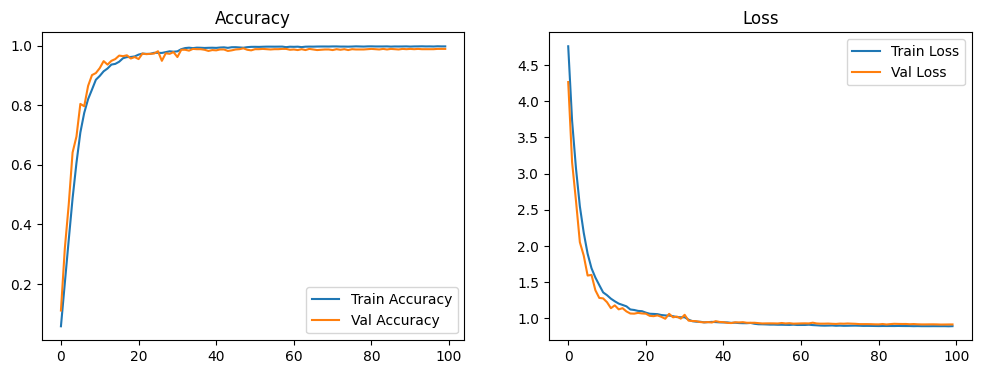

In [6]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 6. Detailed Evaluation Charts

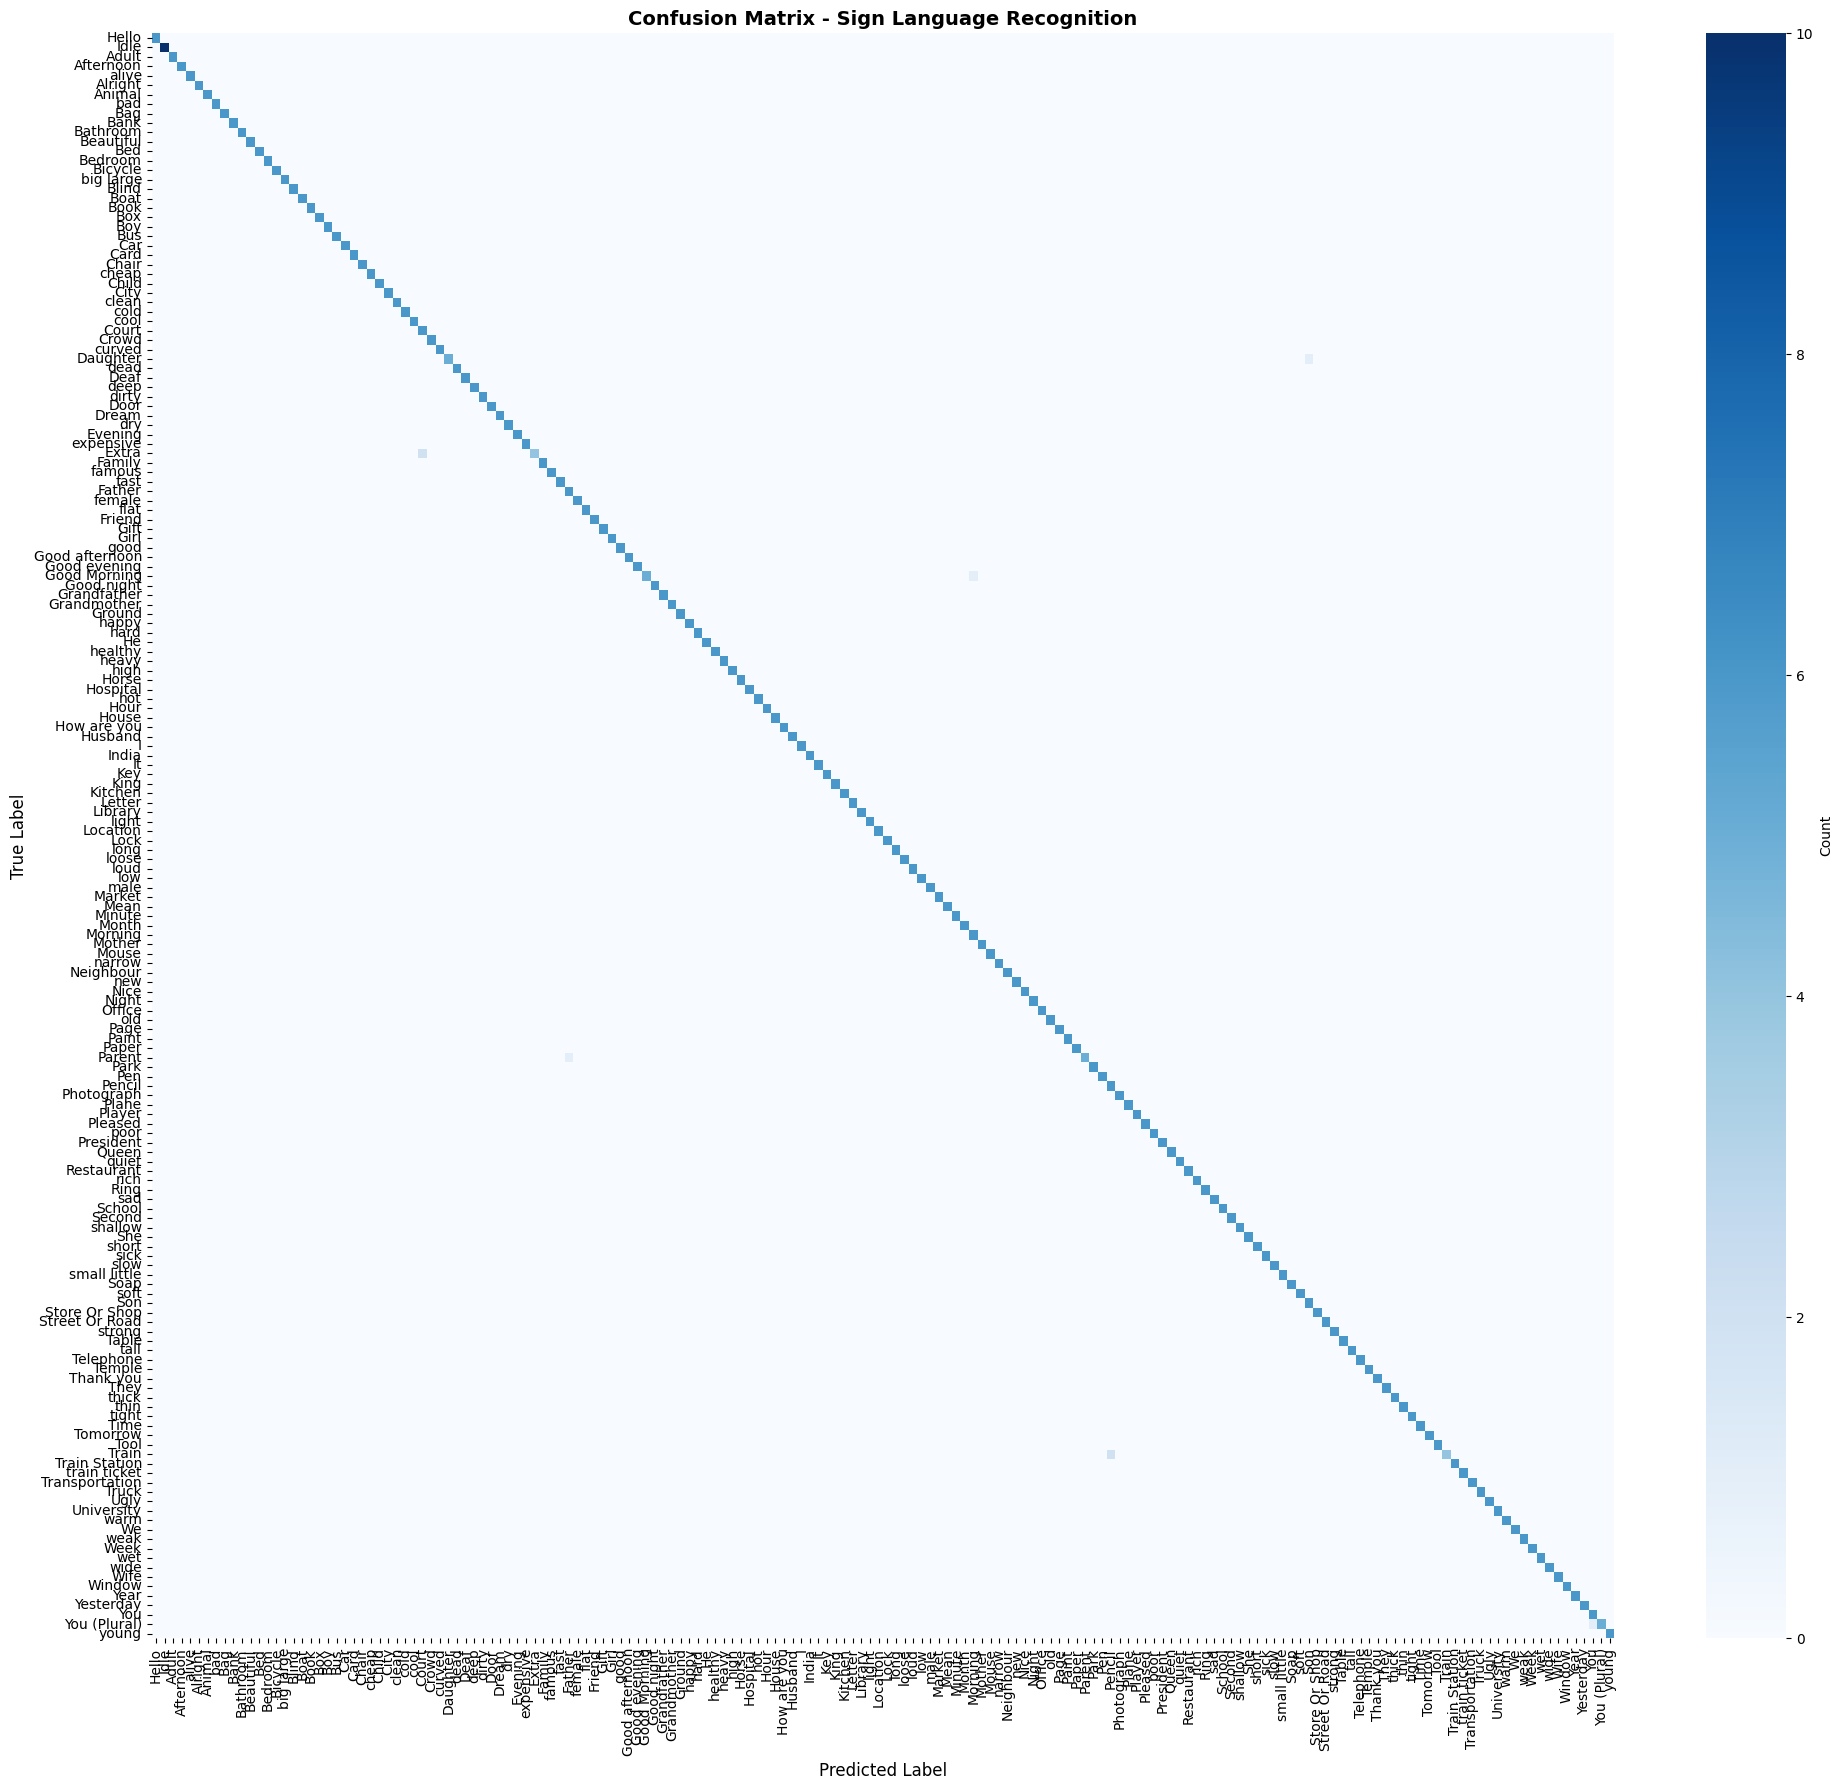

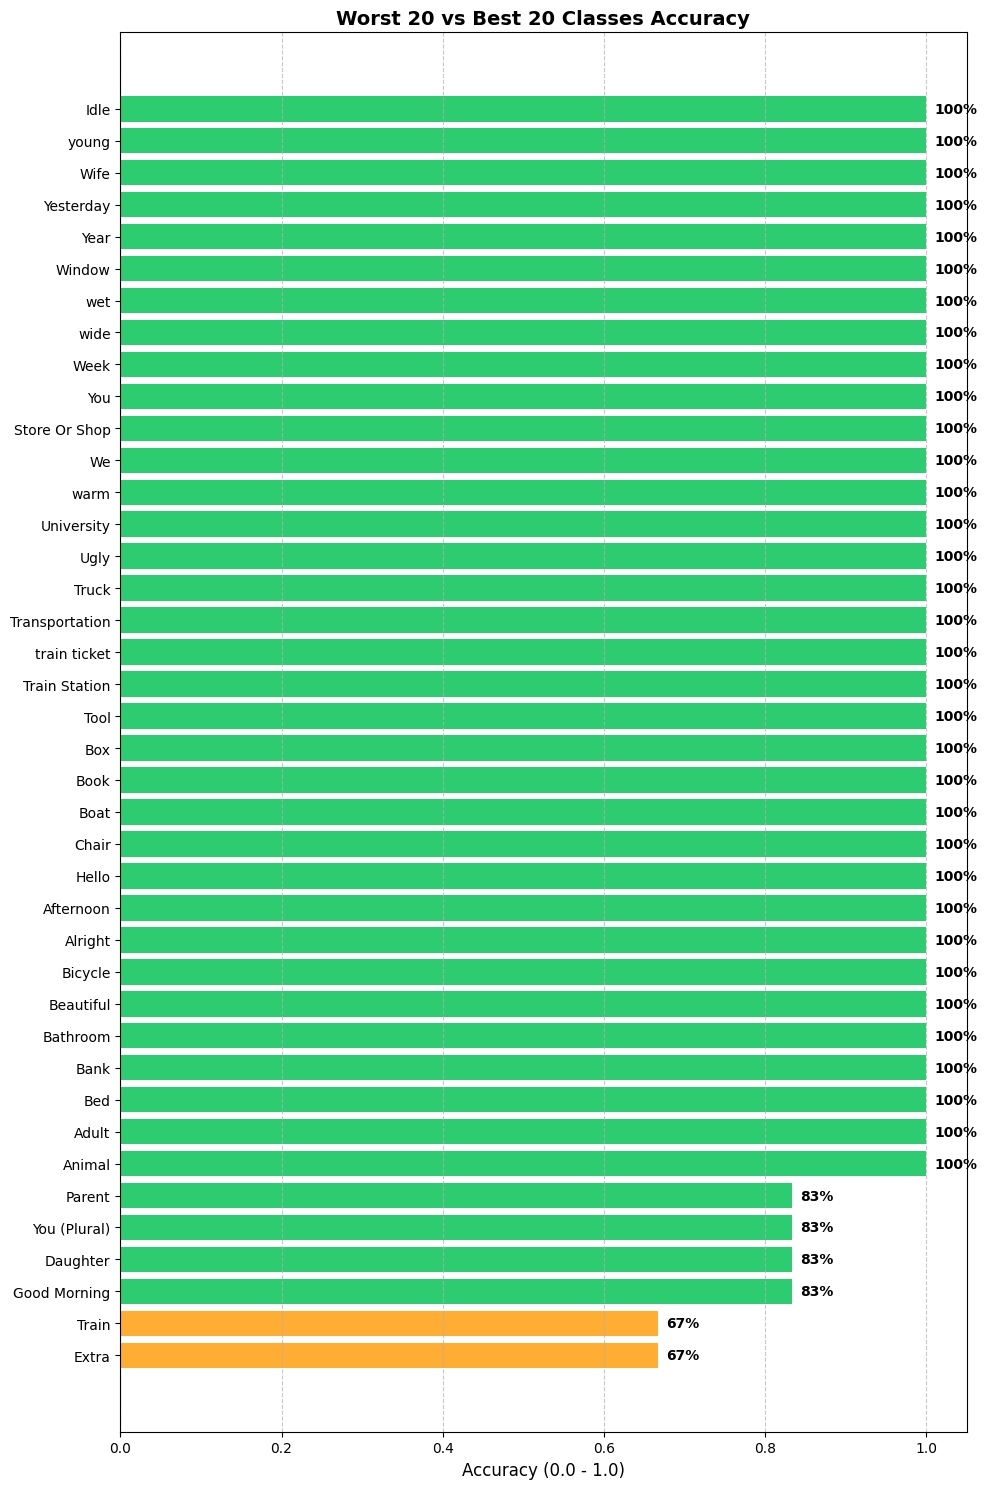

In [7]:
# Generate Predictions
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

cm = confusion_matrix(y_true, y_pred)

# 1. Confusion Matrix Heatmap
try:
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
               xticklabels=actions, yticklabels=actions,
               cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - Sign Language Recognition', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot heatmap: {e}")

# 2. Per-Class Accuracy Chart
try:
    class_accuracies = cm.diagonal() / (cm.sum(axis=1) + 1e-6)
    sorted_indices = np.argsort(class_accuracies)
    sorted_accuracies = class_accuracies[sorted_indices]
    sorted_actions = actions[sorted_indices]

    if len(actions) > 50:
         # Plot worst 20 and best 20
         subset_actions = np.concatenate([sorted_actions[:20], sorted_actions[-20:]])
         subset_accuracies = np.concatenate([sorted_accuracies[:20], sorted_accuracies[-20:]])
         plt.figure(figsize=(10, 15))
         plt.title('Worst 20 vs Best 20 Classes Accuracy', fontsize=14, fontweight='bold')
    else:
         plt.figure(figsize=(10, max(6, len(actions) * 0.3)))
         plt.title('Per-Class Model Fidelity', fontsize=14, fontweight='bold')
         subset_actions = sorted_actions
         subset_accuracies = sorted_accuracies

    colors = ['#ff4d4d' if x < 0.5 else '#ffad33' if x < 0.8 else '#2ecc71' for x in subset_accuracies]

    plt.barh(subset_actions, subset_accuracies, color=colors)
    plt.xlabel('Accuracy (0.0 - 1.0)', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(0, 1.05)

    for i, v in enumerate(subset_accuracies):
        plt.text(v + 0.01, i, f"{v*100:.0f}%", va='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot accuracy chart: {e}")